# 01-Data_Exploration

In [ ]:
%%capture
# %pip install flwr[simulation] torch torchvision matplotlib sklearn openml

In [ ]:
!pip install flwr[simulation] torch torchvision matplotlib scikit-learn openml

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 20.6 MB/s eta 0:00:

In [ ]:
import os
import pandas as pd
import numpy as np
import flwr as fl
from tqdm import tqdm
import warnings
#warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("torch", torch.__version__)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

flwr 1.20.0
numpy 2.0.2
torch 2.8.0+cu126
Training on cpu


In [ ]:
### THIS SECTION NEEDS TO BE SET TO DETERMINE WHICH CONFIGURATION METHOD TO UTILISE

SPLIT_AVAILABLE_METHODS = ['STRATIFIED','LEAVE_ONE_OUT', 'ONE_CLASS', 'HALF_BENIGN' ]
METHOD = 'LEAVE_ONE_OUT'
NUM_OF_STRATIFIED_CLIENTS = 10  # only applies to stratified method
NUM_OF_ROUNDS = 5              # Number of FL rounds


In [ ]:
individual_classifier = True
group_classifier = False
binary_classifier = False


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load and combine all training data
import os
from tqdm import tqdm

# Define dataset directory (adjust path as needed)
DATASET_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/data/CICIoT2023/'

# Load all CSV files
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# Use 80% for training
training_sets = df_sets[:int(len(df_sets)*.8)]

print(f"Loading {len(training_sets)} training files...")

# First, let's check what columns are actually available in the dataset
sample_df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
print(f"Available columns in dataset: {list(sample_df.columns)}")
print(f"Dataset shape: {sample_df.shape}")

# Combine all training data with immediate rounding
combined_df = pd.DataFrame()
for file in tqdm(training_sets):
    df_temp = pd.read_csv(DATASET_DIRECTORY + file)

    # Round numbers immediately after loading each file
    print(f"Rounding numbers in {file}...")
    for col in df_temp.columns:
        if col != 'Label' and df_temp[col].dtype in ['float64', 'float32']:
            # Get max value to determine rounding precision
            col_max = df_temp[col].abs().max()

            if col_max > 1000:
                # Large values: round to 2 decimal places
                df_temp[col] = df_temp[col].round(2)
            elif col_max > 1:
                # Medium values: round to 4 decimal places
                df_temp[col] = df_temp[col].round(4)
            else:
                # Small values (0-1): round to 6 decimal places
                df_temp[col] = df_temp[col].round(6)

    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print("All numbers have been rounded during loading process")

# Use actual column names from the dataset (excluding the Label column)
X_columns = [col for col in combined_df.columns if col != 'Label']
y_column = 'Label'

print(f"Using {len(X_columns)} feature columns")
print(f"Feature columns: {X_columns[:10]}...")  # Show first 10 columns

# Apply label mapping based on classification type
dict_34_classes = {
    'BENIGN': 0, 'DDOS-RSTFINFLOOD': 1, 'DDOS-PSHACK_FLOOD': 2, 'DDOS-SYN_FLOOD': 3,
    'DDOS-UDP_FLOOD': 4, 'DDOS-TCP_FLOOD': 5, 'DDOS-ICMP_FLOOD': 6, 'DDOS-SYNONYMOUSIP_FLOOD': 7,
    'DDOS-ACK_FRAGMENTATION': 8, 'DDOS-UDP_FRAGMENTATION': 9, 'DDOS-ICMP_FRAGMENTATION': 10,
    'DDOS-SLOWLORIS': 11, 'DDOS-HTTP_FLOOD': 12, 'DOS-UDP_FLOOD': 13, 'DOS-SYN_FLOOD': 14,
    'DOS-TCP_FLOOD': 15, 'DOS-HTTP_FLOOD': 16, 'MIRAI-GREETH_FLOOD': 17, 'MIRAI-GREIP_FLOOD': 18,
    'MIRAI-UDPPLAIN': 19, 'RECON-PINGSWEEP': 20, 'RECON-OSSCAN': 21, 'RECON-PORTSCAN': 22,
    'VULNERABILITYSCAN': 23, 'RECON-HOSTDISCOVERY': 24, 'DNS_SPOOFING': 25, 'MITM-ARPSPOOFING': 26,
    'BROWSERHIJACKING': 27, 'BACKDOOR_MALWARE': 28, 'XSS': 29, 'UPLOADING_ATTACK': 30,
    'SQLINJECTION': 31, 'COMMANDINJECTION': 32, 'DICTIONARYBRUTEFORCE': 33
}

dict_8_classes = {
    0: 0,  # Benign
    1:1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1,  # DDoS
    13: 7, 14: 7, 15: 7, 16: 7,  # DoS
    17: 2, 18: 2, 19: 2,  # Mirai
    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,  # Reconnaissance
    25: 4, 26: 4,  # Spoofing
    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,  # Web
    33: 6  # Brute Force
}

dict_2_classes = {
    0: 0,  # Benign
    1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,
    17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1,
    27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1  # All attacks as malicious
}

# Apply label mapping
combined_df['Label'] = combined_df['Label'].map(dict_34_classes)

if group_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_8_classes)
elif binary_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_2_classes)

# Remove rows with missing labels
combined_df = combined_df.dropna(subset=['Label'])
combined_df['Label'] = combined_df['Label'].astype(int)

print(f"Label distribution:\n{combined_df['Label'].value_counts().sort_index()}")


Loading 4 training files...
Available columns in dataset: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label']
Dataset shape: (712311, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 25%|██▌       | 1/4 [00:08<00:26,  8.88s/it]

Rounding numbers in Merged01.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Rounding numbers in Merged02.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:15<00:14,  7.33s/it]

Rounding numbers in Merged03.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:22<00:07,  7.22s/it]

Rounding numbers in Merged04.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 4/4 [00:27<00:00,  6.80s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Combined dataset shape: (2834805, 40)
All numbers have been rounded during loading process
Using 39 feature columns
Feature columns: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number']...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Label distribution:
Label
0      66396
1     244023
2     247295
3     245610
4     326263
5     270683
6     432865
7     217410
8      17330
9      17271
10     27248
11      1380
12      1766
13    199952
14    121972
15    160806
16      4426
17     59802
18     45003
19     53710
20       141
21      5795
22      4962
23     22623
24      8165
25     10938
26     18654
27       344
28       180
29       258
30        84
31       323
32       313
33       814
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Training data

In [ ]:
# Check to see if the file 'training_data.pkl' exists in the directory. If it does, load it. If not, print an error.
if os.path.isfile('training_data.pkl'):
    print("File exists, loading data...")
    train_df = pd.read_pickle('training_data.pkl')
    print("Training data loaded from pickle file.")

else:
    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Training sets: {}'.format(len(training_sets)))
    print('Test sets: {}'.format(len(test_sets)))

    # ######################
    # # TEMP CODE - This would replicate the original authors code with the last CSV
    # # for training data. Uncomment this section to use this code.
    # ######################
    # # Set training_sets to the last entry of training_sets
    # training_sets = training_sets[-33:]
    # print(f"TO REPLICATE ORIGINAL AUTHORS CODE WITH ONE FILE TRAIN - {training_sets}")
    # #####################
    # # END TEMP CODE
    # ######################

    # Concatenate all training sets into one dataframe
    dfs = []
    print("Reading training data...")
    for train_set in tqdm(training_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
        dfs.append(df_new)
    train_df = pd.concat(dfs, ignore_index=True)

    # Complete training data set size
    print("Complete training data size: {}".format(train_df.shape))

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    train_df['Label'] = train_df['Label'].map(dict_34_classes)

    # The training data is the 80% of the CSV files in the dataset. The test data is the remaining 20%.
    # The Ray Federated learning mechanism cannot cope with all of the 80% training data, so we will split
    # the training data using test_train_split. The test data will be ignored as we will use all the data
    # from the train_sets files as our training data to keep parity with the original authors code.
    #
    # By using a subset of the training data split this way, we can have a randomised selection of data
    # from all the training CSV files, stratified by the attack types.

    # Percentage of original training data to use.
    TRAIN_SIZE = 0.99

    print(f"Splitting the data into {TRAIN_SIZE*100}%")

    X_train, X_test, y_train, y_test = train_test_split(train_df[X_columns], train_df[y_column], test_size= (1 - TRAIN_SIZE), random_state=42, stratify=train_df[y_column])

    # Recombine X_train, and y_train into a dataframe
    train_df = pd.concat([X_train, y_train], axis=1)

    # Clean up unused variables

    del X_train, y_train, X_test, y_test

    # Save the output to a pickle file
    print("Writing training data to pickle file...")
    train_df.to_pickle('training_data.pkl')

print("Training data size: {}".format(train_df.shape))

Training sets: 4
Test sets: 1
Reading training data...


 25%|██▌       | 1/4 [00:02<00:08,  2.68s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:07<00:07,  3.69s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:09<00:03,  3.22s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent date

Complete training data size: (2834805, 40)
Splitting the data into 99.0%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing training data to pickle file...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training data size: (2806456, 40)


In [ ]:
# show the unique values counts in the label column for train_df
print("Counts of attacks in train_df:")
print(train_df['Label'].value_counts())

Counts of attacks in train_df:
Label
6     428536
4     323000
5     267976
2     244822
3     243154
1     241583
7     215236
13    197952
15    159198
14    120752
0      65732
17     59204
19     53173
18     44553
10     26976
23     22397
26     18467
8      17157
9      17098
25     10829
24      8083
21      5737
22      4912
16      4382
12      1748
11      1366
33       806
27       341
31       320
32       310
29       255
28       178
20       140
30        83
Name: count, dtype: int64


In [ ]:
train_df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
106878,20.00,6,64.00,66313.106719,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000065,100,0.000000,7
1146355,20.00,6,64.00,26442.466272,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000038,100,0.000000,3
1166244,8.00,17,64.00,6952.614915,0.00,0.0,0.00,0.0,0.0,0.0,...,55400,554,554,554.00,0.000000,554.00,0.000160,100,0.000000,19
2670446,20.00,6,64.00,34433.166407,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000029,100,0.000000,3
380158,7.20,17,83.10,8807.492335,0.00,0.0,0.00,0.0,0.0,0.0,...,6100,60,70,61.00,3.015113,61.00,0.000114,100,9.090909,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443499,19.68,6,62.76,15858.081591,0.98,0.0,0.98,0.0,0.0,0.0,...,6303,60,363,63.03,30.300000,63.03,0.000064,100,918.090000,1
1029352,0.00,1,64.00,32564.472050,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000031,100,0.000000,6
323791,20.00,6,64.00,48663.464439,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000021,100,0.000000,5
354404,20.00,6,64.00,17346.170389,0.00,0.0,0.00,1.0,1.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000058,100,0.000000,2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Test Data

In [ ]:
# Check to see if the file 'test_data.pkl' exists in the directory. If it does, load it. If not, print an error.
testing_data_pickle_file = 'testing_data.pkl'

if os.path.isfile(testing_data_pickle_file):
    print(f"File {testing_data_pickle_file} exists, loading data...")
    test_df = pd.read_pickle(testing_data_pickle_file)
    print("Test data loaded from pickle file.")

else:
    print(f"File {testing_data_pickle_file} does not exist, constructing data...")

    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Test sets: {}'.format(len(test_sets)))

    # Concatenate all testing sets into one dataframe
    dfs = []
    print("Reading test data...")
    for test_set in tqdm(test_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + test_set)
        dfs.append(df_new)
    test_df = pd.concat(dfs, ignore_index=True)

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    test_df['Label'] = test_df['Label'].map(dict_34_classes)

    # Save the output to a pickle file
    print(f"Writing test data to pickle file {testing_data_pickle_file}...")
    test_df.to_pickle(testing_data_pickle_file)

print("Testing data size: {}".format(test_df.shape))

File testing_data.pkl does not exist, constructing data...
Test sets: 1
Reading test data...


100%|██████████| 1/1 [00:07<00:00,  7.83s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 1/1 [00:07<00:00,  7.83s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing test data to pickle file testing_data.pkl...
Testing data size: (744804, 40)


In [ ]:
print("Number of rows in train_df: {}".format(len(train_df)))
print("Number of rows in test_df: {}".format(len(test_df)))

train_size = len(train_df)
test_size = len(test_df)

Number of rows in train_df: 2806456
Number of rows in test_df: 744804



# Scale the test and train data


Scale the training data input features

In [ ]:
scaler = StandardScaler()

# Check for and handle infinite values
print("Checking for and handling infinite values...")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed.")

train_df[X_columns] = scaler.fit_transform(train_df[X_columns])

Checking for and handling infinite values...
Infinite values handled and rows with NaN removed.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Check for and handle infinite values
print("Checking for and handling infinite values in test data...")
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed from test data.")

# Fit the scaler on the training data and then transform the test data
#scaler.fit(train_df[X_columns])
test_df[X_columns] = scaler.transform(test_df[X_columns])

Checking for and handling infinite values in test data...
Infinite values handled and rows with NaN removed from test data.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
class_size_map = {2: "Binary", 8: "Group", 34: "Individual"}

if group_classifier:
    print("Group 8 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_7_classes values
    test_df['label'] = test_df['label'].map(dict_8_classes)
    train_df['label'] = train_df['label'].map(dict_8_classes)
    class_size = "8"

elif binary_classifier:
    print("Binary 2 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_2_classes values
    test_df['label'] = test_df['label'].map(dict_2_classes)
    train_df['label'] = train_df['label'].map(dict_2_classes)
    class_size = "2"

else:
    print ("Individual 34 Class classifier... - No adjustments to labels in test and train dataframes")
    class_size = "34"

Individual 34 Class classifier... - No adjustments to labels in test and train dataframes


# Split the Training Data into partitions for the Federated Learning clients depending on the test required

In [ ]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the colours used for text printing
from enum import Enum
class Colours(Enum):
    RED = "\033[31m"
    YELLOW = "\033[33m"
    NORMAL = "\033[0m"

# Define fl_X_train and fl_y_train
fl_X_train = []
fl_y_train = []

client_df = pd.DataFrame()

# Define the target label column
y_column = 'Label'

# STRATIFIED method: evenly distribute class labels across clients
if METHOD == 'STRATIFIED':
    print(f"{Colours.YELLOW.value}STRATIFIED METHOD{Colours.NORMAL.value} with {class_size} class classifier")
    skf = StratifiedKFold(n_splits=NUM_OF_STRATIFIED_CLIENTS, shuffle=True, random_state=42)
    for _, test_index in skf.split(train_df[X_columns], train_df[y_column]):
        fl_X_train.append(train_df.iloc[test_index][X_columns])
        fl_y_train.append(train_df.iloc[test_index][y_column])

# LEAVE_ONE_OUT: remove one class (or benign) from each client’s dataset
elif METHOD == 'LEAVE_ONE_OUT':
    print(f"{Colours.YELLOW.value}LEAVE_ONE_OUT METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: exclude attack class 1
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Exclude one specific attack class
            client_df = current_fold_df[current_fold_df[y_column] != (i + 1)].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# ONE_CLASS: each client has Benign + 1 attack class only
elif METHOD == 'ONE_CLASS':
    print(f"{Colours.YELLOW.value}ONE_CLASS METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: only Benign data
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Include only Benign and the (i+1)-th attack class
            mask = (current_fold_df[y_column] == 0) | (current_fold_df[y_column] == (i + 1))
            client_df = current_fold_df[mask].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# HALF_BENIGN: alternate clients between only-benign and full-class datasets
elif METHOD == 'HALF_BENIGN':
    print(f"{Colours.YELLOW.value}HALF_BENIGN METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if i % 2 == 0:
            # Even-indexed clients: only Benign data
            client_df = current_fold_df[current_fold_df[y_column] == 0].copy()
        else:
            # Odd-indexed clients: all data
            client_df = current_fold_df.copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# Handle unknown METHOD value
else:
    print(f"{Colours.RED.value}ERROR: Method {METHOD} not recognised{Colours.NORMAL.value}")

# Update the number of clients created


LEAVE_ONE_OUT METHOD with 34 class classifier


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Model Poisoning Attack
print("--- Applying Model Poisoning ---")
num_malicious_clients = 11  # about 33% of 33 clients
malicious_client_ids = list(range(num_malicious_clients))
target_class = 6 # 'DDOS-ICMP_FLOOD' - This is the most frequent class
new_class = 0    # 'BENIGN'
poison_fraction = 1.0 # poison 100% of the target class samples in malicious clients

print(f"Poisoning {num_malicious_clients} clients: {malicious_client_ids}")
print(f"Flipping label from {target_class} to {new_class} for {poison_fraction*100}% of samples of malicious clients.")

for client_id in malicious_client_ids:
    # fl_y_train[client_id] is a pandas Series.
    # We can get the indices of the target class and replace the labels.
    y_train_series = fl_y_train[client_id]
    target_indices = y_train_series[y_train_series == target_class].index
    
    num_to_poison = int(len(target_indices) * poison_fraction)
    
    # Randomly select indices to poison
    poison_indices = np.random.choice(target_indices, num_to_poison, replace=False)
    
    # Flip the labels in the pandas Series
    fl_y_train[client_id].loc[poison_indices] = new_class
    
    print(f"Client {client_id}: Flipped {len(poison_indices)} labels from class {target_class} to {new_class}.")

print("--- Model Poisoning Applied ---")


In [ ]:
# Update the number of clients created
NUM_OF_CLIENTS = len(fl_X_train)
# --- Inspect the training data for each client ---
for i in range(NUM_OF_CLIENTS):
    print(f"\n--- Client ID: {i} ---")
    print(f"fl_X_train[{i}].shape: {fl_X_train[i].shape}")
    print(f"fl_y_train[{i}].value_counts():\n{fl_y_train[i].value_counts()}")
    print(f"fl_y_train[{i}].unique(): {fl_y_train[i].unique()}")

# Check if two clients have identical feature data
print(f"\nfl_X_train[0].equals(fl_X_train[1]): {fl_X_train[0].equals(fl_X_train[1])}")


--- Client ID: 0 ---
fl_X_train[0].shape: (77723, 39)
fl_y_train[0].value_counts():
Label
6     12985
4      9788
5      8121
2      7419
3      7368
7      6523
13     5998
15     4825
14     3659
0      1992
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16      133
12       53
11       41
33       25
27       11
31        9
32        9
29        8
20        5
28        5
30        3
Name: count, dtype: int64
fl_y_train[0].unique(): [ 4  6 13 18 25 19 24  2  5  7 14 15  3 17 10 23 11  8  0 33 26 22 12 21
  9 16 27 30 29 28 20 31 32]

--- Client ID: 1 ---
fl_X_train[1].shape: (77624, 39)
fl_y_train[1].value_counts():
Label
6     12985
4      9788
5      8121
3      7368
1      7320
7      6523
13     5998
15     4825
14     3659
0      1992
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16    

Visualize Data Distribution

STRATIFIED Client

In [ ]:
#STRATIFIED Client

In [ ]:
#LEAVE_ONE_OUT

In [ ]:
#Half begign

In [ ]:
#One class

/tmp/ipython-input-3333892375.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap('tab20', 20)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


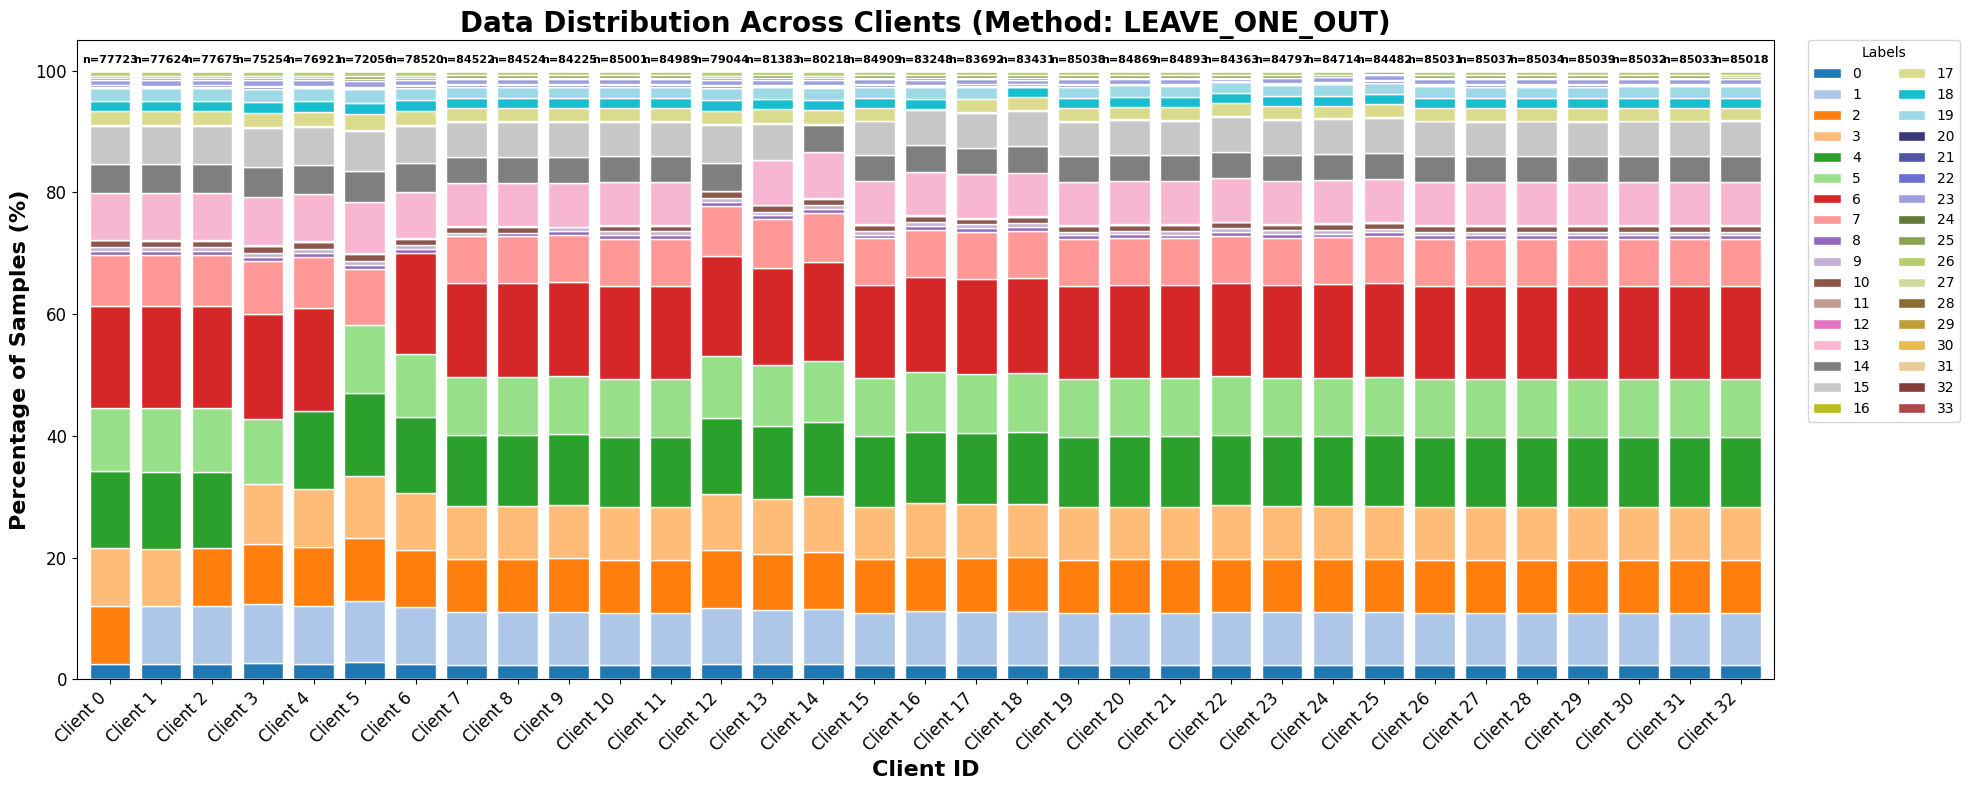

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
client_distributions = {}
for i in range(NUM_OF_CLIENTS):
    # .value_counts() returns a Series, convert it to a dictionary
    client_distributions[f'Client {i}'] = fl_y_train[i].value_counts().to_dict()

# 2. Convert the dictionary to a Pandas DataFrame for easy manipulation
df_dist = pd.DataFrame(client_distributions).fillna(0).astype(int)
df_dist = df_dist.sort_index() # Sort the labels numerically for consistent colors

# 3. Plot a Stacked Bar Chart
# Convert absolute counts to percentages for the chart y-axis
df_percent = df_dist.divide(df_dist.sum(axis=0), axis=1) * 100

# Create a diverse color palette to ensure distinct colors for all 34 labels
# We combine multiple colormaps to get enough unique colors
colors1 = plt.cm.get_cmap('tab20', 20)
colors2 = plt.cm.get_cmap('tab20b', 20)
colors = np.vstack((colors1.colors, colors2.colors))

# Plot the chart with a much wider figure size
ax = df_percent.T.plot(
    kind='bar',
    stacked=True,
    figsize=(22, 8), # Increased width for readability
    color=colors,
    width=0.8,
    edgecolor="white"
)

# 4. Customize the plot for better presentation
plt.title(f'Data Distribution Across Clients (Method: {METHOD})', fontsize=20, fontweight='bold')
plt.xlabel('Client ID', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of Samples (%)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for better fit
plt.yticks(fontsize=12)
plt.ylim(0, 105) # Add a little space at the top for annotations

# Move the legend outside the plot and arrange it in 2 columns
plt.legend(
    title='Labels',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize='medium',
    ncol=2 # Arrange legend in two columns
)

# Adjust layout to prevent the legend from being cut off
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add total sample count (n=...) above each bar for context
for i, total in enumerate(df_dist.sum(axis=0)):
    ax.text(i, 101, f'n={total}', ha='center', va='bottom', fontsize=8, fontweight='bold')

#  plt.show()

Prepare an output directory where we can store the results of the federated learning

In [ ]:
# Create an "Output" directory if it doesnt exist already
if not os.path.exists("Output"):
    os.makedirs("Output")

sub_dir_name = f"train_size-{train_size}"

# if sub_dir_name does not exist, create it
if not os.path.exists(f"Output/{sub_dir_name}"):
    os.makedirs(f"Output/{sub_dir_name}")

test_directory_name = f"{METHOD}_Classifier-{class_size}_Clients-{NUM_OF_CLIENTS}"
output_path = f"Output/{sub_dir_name}/{test_directory_name}" # Lưu lại đường dẫn để dùng sau

# Create an "Output/{METHOD}-{NUM_OF_CLIENTS}-{NUM_OF_ROUNDS}" directory if it doesnt exist already
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Ensure the directory is empty
for file in os.listdir(output_path):
    file_path = os.path.join(output_path, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)

# Original training size is the sum of all the fl_X_train sizes
original_training_size = 0
for i in range(len(fl_X_train)):
    original_training_size += fl_X_train[i].shape[0]

# Write this same info to the output directory/Class Split Info.txt
with open(f"{output_path}/Class Split Info.txt", "w") as f:
    for i in range(len(fl_X_train)):
        f.write(f"Client ID: {i}\n")
        f.write(f"fl_X_train.shape: {fl_X_train[i].shape}\n")
        f.write(f"Training data used {original_training_size}\n")
        f.write(f"fl_y_train.value_counts():\n{fl_y_train[i].value_counts().to_string()}\n")
        f.write(f"fl_y_train.unique(): {fl_y_train[i].unique()}\n\n")

print(f"Output directory and summary file created at: {output_path}")

Output directory and summary file created at: Output/train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33


Convert the training dataset


In [ ]:
# Convert the testing dataframe to numpy arrays for TensorFlow/Keras
X_test = test_df[X_columns].to_numpy()
y_test = test_df[y_column].to_numpy()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Determine the number of unique classes in the target column
num_unique_classes = len(train_df[y_column].unique())

# Store the shapes of the original dataframes for logging purposes before deleting them
train_df_shape = train_df.shape
test_df_shape = test_df.shape

# Now that we have fl_X_train, fl_y_train, X_test, and y_test extracted,
# we can safely delete the large dataframes to free up memory
if 'train_df' in locals():
    del train_df
if 'test_df' in locals():
    del test_df
if 'client_df' in locals():
    del client_df
print("Final data conversion to numpy complete. Dataframes deleted to free up memory.")

Final data conversion to numpy complete. Dataframes deleted to free up memory.


Data check

In [ ]:
print("NUM_CLIENTS:", NUM_OF_CLIENTS)

print("NUM_ROUNDS:", NUM_OF_ROUNDS)
print()


print("Original training size: {}".format(original_training_size))


print("Checking training data split groups")
for i in range(len(fl_X_train)):
    print(i, ":", "X Shape", fl_X_train[i].shape, "Y Shape", fl_y_train[i].shape)


# Print the sizes of X_test and y_test
print("\nChecking testing data")
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

print("\nDeploy Simulation")

NUM_CLIENTS: 33
NUM_ROUNDS: 5

Original training size: 2723339
Checking training data split groups
0 : X Shape (77723, 39) Y Shape (77723,)
1 : X Shape (77624, 39) Y Shape (77624,)
2 : X Shape (77675, 39) Y Shape (77675,)
3 : X Shape (75254, 39) Y Shape (75254,)
4 : X Shape (76921, 39) Y Shape (76921,)
5 : X Shape (72056, 39) Y Shape (72056,)
6 : X Shape (78520, 39) Y Shape (78520,)
7 : X Shape (84522, 39) Y Shape (84522,)
8 : X Shape (84524, 39) Y Shape (84524,)
9 : X Shape (84225, 39) Y Shape (84225,)
10 : X Shape (85001, 39) Y Shape (85001,)
11 : X Shape (84989, 39) Y Shape (84989,)
12 : X Shape (79044, 39) Y Shape (79044,)
13 : X Shape (81383, 39) Y Shape (81383,)
14 : X Shape (80218, 39) Y Shape (80218,)
15 : X Shape (84909, 39) Y Shape (84909,)
16 : X Shape (83248, 39) Y Shape (83248,)
17 : X Shape (83692, 39) Y Shape (83692,)
18 : X Shape (83431, 39) Y Shape (83431,)
19 : X Shape (85038, 39) Y Shape (85038,)
20 : X Shape (84869, 39) Y Shape (84869,)
21 : X Shape (84893, 39) Y Sh

In [ ]:
print("X_test min/max/mean:", np.min(X_test), np.max(X_test), np.mean(X_test))
print("Client 0 X min/max/mean:", np.min(fl_X_train[0]), np.max(fl_X_train[0]), np.mean(fl_X_train[0]))

X_test min/max/mean: -52.92539879493338 476.80242930958366 -0.000634890663062242
Client 0 X min/max/mean: -52.92539879493338 136.22155747982657 -0.02330975502083858


#Federated Learning

Import the libraries and print the versions


In [ ]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


Define the Client and Server code

In [ ]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

print('scikit-learn {}.'.format(sklearn.__version__))
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tf", tf.__version__)
# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

import datetime

client_evaluations = []

class NumpyFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_data, train_labels):
        self.model = model
        self.cid = cid
        self.train_data = train_data
        self.train_labels = train_labels

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Training...")
        self.model.fit(self.train_data, self.train_labels, epochs=5, batch_size=32)
        print ("Client ", self.cid, "Training complete...")
        return self.model.get_weights(), len(self.train_data), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Evaluating...")
        loss, accuracy = self.model.evaluate(self.train_data, self.train_labels, batch_size=32)
        print(f"{Colours.YELLOW.value}Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}{Colours.NORMAL.value}")

        # Write the same message to the "Output/{cid}_Evaluation.txt" file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/{self.cid}_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}\n")

            # Close the file
            f.close()

        return loss, len(self.train_data), {"accuracy": accuracy}

    def predict(self, incoming):
        prediction = np.argmax( self.model.predict(incoming) ,axis=1)
        return prediction

def client_fn(cid: str) -> NumpyFlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    #model = tf.keras.applications.MobileNetV2((32, 32, 3), classes=10, weights=None)
    #model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    print ("Client ID:", cid)

    model = Sequential([
      #Flatten(input_shape=(79,1)),
      Dense(50, activation='relu', input_shape=(fl_X_train[0].shape[1],)),
      Dense(25, activation='relu'),
      Dense(num_unique_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    partition_id = int(cid)
    X_train_c = fl_X_train[partition_id]
    y_train_c = fl_y_train[partition_id]

    # Create a  single Flower client representing a single organization
    return NumpyFlowerClient(cid, model, X_train_c, y_train_c)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
eval_count = 0

def get_evaluate_fn(server_model):
    global eval_count

    def evaluate(server_round, parameters, config):
        global eval_count

        # Update model weights from the latest client parameters
        server_model.set_weights(parameters)
        print(f"Server Evaluating... Evaluation Count: {eval_count}")

        # Evaluate the model on the test set
        loss, accuracy = server_model.evaluate(X_test, y_test)

        # Record accuracy and loss for visualization or tracking
        server_accuracy_history.append(accuracy)
        server_loss_history.append(loss)

        # Make predictions and save them to a file
        y_pred = server_model.predict(X_test)
        print("Prediction: ", y_pred, y_pred.shape)
        np.save("y_pred-" + str(eval_count) + ".npy", y_pred)

        # Print evaluation result to console
        print(f"{Colours.YELLOW.value}Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}{Colours.NORMAL.value}")

        # Write evaluation log to file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/Server_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - {server_round} : Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}\n")

        # Increment evaluation counter
        eval_count += 1

        return loss, {"accuracy": accuracy}

    return evaluate



scikit-learn 1.6.1.
flwr 1.20.0
numpy 2.0.2
tf 2.19.0


Initialize Server Model and Strategy

In [ ]:
from flwr.common import ndarrays_to_parameters
server_model = Sequential([
    #Flatten(input_shape=(79,1)),
    Flatten(input_shape=(fl_X_train[0].shape[1] , 1)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(num_unique_classes, activation='softmax')
])


server_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

initial_weights = server_model.get_weights()
initial_parameters = ndarrays_to_parameters(initial_weights)
# Create FedAvg strategy
# strategy = fl.server.strategy.FedAvg(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10, #10,
#         min_evaluate_clients=5, #5,
#         min_available_clients=10, #10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         #evaluate_metrics_aggregation_fn=weighted_average,
# )
# Test FedAdam


strategy = fl.server.strategy.FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,==
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_fn=get_evaluate_fn(server_model),
        eta=1.0,           # Server-side learning rate
        beta_1=0.9,
        beta_2=0.999,
        tau=1e-9,
        initial_parameters=initial_parameters
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Deploy Simulation

In [ ]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOG START ---
print(f"{Colours.YELLOW.value}\nDeploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}\n")
print(f"Writing output to: {sub_dir_name}/{test_directory_name}\n{Colours.NORMAL.value}")

# Ghi thông tin ban đầu vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - Deploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Number of Clients = {NUM_OF_CLIENTS}\n")
    f.write(f"{datetime.datetime.now()} - Original train_df size: {train_df_shape}\n")

    for i in range(len(fl_X_train)):
        f.write(f"{datetime.datetime.now()} - {i}: X Shape {fl_X_train[i].shape}, Y Shape {fl_y_train[i].shape}\n")

    f.write(f"{datetime.datetime.now()} - X_test size: {X_test.shape}\n")
    f.write(f"{datetime.datetime.now()} - y_test size: {y_test.shape}\n")

# --- START SIMULATION ---
start_time = datetime.datetime.now()

ray_init_args = {"num_cpus": 2}

server_accuracy_history = []
server_loss_history = []

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_OF_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_OF_ROUNDS),
    strategy=strategy,
    client_resources={"num_cpus": 1},
    ray_init_args=ray_init_args,
)

end_time = datetime.datetime.now()
print("Total time taken: ", end_time - start_time)

# --- LOG END ---
print(f"{Colours.YELLOW.value}SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}{Colours.NORMAL.value}\n")

# Ghi thông tin kết thúc vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Total time taken: {end_time - start_time}\n")

# --- PLOT ACCURACY ---
plt.figure(figsize=(10, 4))
plt.plot(server_accuracy_history, marker='o')
plt.title('Server Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_accuracy_per_round.png")
plt.show()

# --- PLOT LOSS ---
plt.figure(figsize=(10, 4))
plt.plot(server_loss_history, marker='o', color='red')
plt.title('Server Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_loss_per_round.png")
plt.show()


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout



Deploy simulation... Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33

Writing output to: train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-08-21 12:35:32,252	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3985029120.0, 'memory': 7970058240.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=73104) WARNING: All log messages before absl::InitializeLog()

(ClientAppActor pid=73104) Client ID: 6
Server Evaluating... Evaluation Count: 6
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - accuracy: 0.0975 - loss: 3.4588
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step


INFO :      initial parameters (loss, other metrics): 3.4582533836364746, {'accuracy': 0.09759126603603363}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


Prediction:  [[0.04086504 0.02916454 0.03045636 ... 0.03305735 0.03425913 0.03023548]
 [0.08785965 0.01919478 0.03455594 ... 0.01703503 0.03764409 0.01992432]
 [0.03048049 0.04153264 0.02838248 ... 0.02830165 0.02691007 0.0190301 ]
 ...
 [0.04928403 0.08155701 0.0248627  ... 0.01750859 0.0094008  0.00531493]
 [0.03153794 0.0350408  0.02613751 ... 0.02788089 0.03663879 0.02850264]
 [0.03301866 0.03159193 0.02604986 ... 0.02740715 0.03869477 0.0305524 ]] (744790, 34)
Server evaluation complete - Accuracy: 0.0976, Loss: 3.4583


(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104)         
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73104)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73104) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73104) Client ID: 1
(ClientAppActor pid=73104) Client  1 Training...
(ClientAppActor pid=73104) Epoch 1/5
(ClientAppActor pid=73102) Client ID: 27


(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73102)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  18/2426 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1525 - loss: 3.3776    
  54/2426 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3011 - loss: 3.1011
  89/2426 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3745 - loss: 2.8498
 121/2426 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4147 - loss: 2.6548
  45/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2714 - loss: 3.1824
 147/2426 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4397 - loss: 2.5174
(ClientAppActor pid=73102) Client  27 Training...
(ClientAppActor pid=73102) Epoch 1/5
1117/2426 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6262 - loss: 1.2271
  15/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1713 - loss: 3.3389   
1290/2426 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6340 - loss: 1.1678 [repeated 88x across cluster]
1730/2426 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6475 - loss: 1.0603
1792/2426 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6490 - loss: 1.0485 [repeated 6x across cluster]

(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)         
(ClientAppActor pid=73102) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the fi

(ClientAppActor pid=73104) Client  31 Training...
(ClientAppActor pid=73104) Epoch 1/5
1555/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7489 - loss: 0.4887 [repeated 77x across cluster]
1692/2658 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7488 - loss: 0.4887
   6/2658 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.1288 - loss: 3.4175  
  28/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2157 - loss: 3.2656
  49/2658 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.2960 - loss: 3.1218
  63/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3346 - loss: 3.0231
  83/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3764 - loss: 2.8838
  99/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4024 - loss: 2.7790
 115/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4229 - loss: 2.6830
 129/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4382 - loss: 2.6047
 145/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4534 - loss: 2.5216
 160/2658 ━━━━━━━━━━━━━━

(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73102)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73102) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

 788/2658 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6238 - loss: 1.3691
(ClientAppActor pid=73102) Client  22 Training...
 813/2658 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6259 - loss: 1.3529
(ClientAppActor pid=73102) Epoch 1/5
 846/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6285 - loss: 1.3326
 872/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6305 - loss: 1.3174
 904/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6328 - loss: 1.2996
 932/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6347 - loss: 1.2847
 954/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6361 - loss: 1.2735
  18/2637 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1323 - loss: 3.2798    
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7483 - loss: 0.4879 [repeated 2x across cluster]
1811/2658 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6694 - loss: 1.0137 [repeated 50x across cluster]
2468/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6823 - loss: 0.9

(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)         
(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73104)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73104) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73104) Client ID: 25
(ClientAppActor pid=73104) Client  25 Training...
(ClientAppActor pid=73104) Epoch 1/5
1447/2637 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7519 - loss: 0.4773
1524/2637 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7519 - loss: 0.4771 [repeated 5x across cluster]
  16/2641 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1453 - loss: 3.3765    
 249/2641 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5276 - loss: 2.1167 [repeated 70x across cluster]


(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73102)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73102) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73102) Client  22 Training complete...
(ClientAppActor pid=73102) Client ID: 16
(ClientAppActor pid=73102) Client  16 Training...
(ClientAppActor pid=73102) Epoch 1/5
  17/2602 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1476 - loss: 3.3568    
1567/2641 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6719 - loss: 1.0511 [repeated 75x across cluster]
 607/2602 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6108 - loss: 1.5008
 697/2602 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6218 - loss: 1.4215 
2447/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6899 - loss: 0.9059 [repeated 91x across cluster]
1930/2641 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6810 - loss: 0.9784 [repeated 3x across cluster]
(ClientAppActor pid=73104) Epoch 2/5
   1/2641 ━━━━━━━━━━━━━━━━━━━━ 1:50 42ms/step - accuracy: 0.7188 - loss: 0.4512
  31/2641 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7547 - loss: 0.4935
1322/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7394 -

(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)         
(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73104)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73104) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73104) Client ID: 20
(ClientAppActor pid=73104) Client  20 Training...
(ClientAppActor pid=73104) Epoch 1/5
1846/2602 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7592 - loss: 0.4718
1882/2602 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7592 - loss: 0.4718
2320/2602 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7589 - loss: 0.4721 [repeated 52x across cluster]
   1/2653 ━━━━━━━━━━━━━━━━━━━━ 2:59:53 4s/step - accuracy: 0.0938 - loss: 3.3754
  19/2653 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.1486 - loss: 3.3149
  40/2653 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.2420 - loss: 3.1703
2388/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7589 - loss: 0.4721 [repeated 7x across cluster]
  55/2653 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2934 - loss: 3.0655
  66/2653 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.3235 - loss: 2.9876
  86/2653 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3678 - loss: 2.8497
2598/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 

(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73102)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73102) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

 183/2653 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.4820 - loss: 2.3234
(ClientAppActor pid=73102) Client  28 Training...
 214/2653 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.5027 - loss: 2.2053
(ClientAppActor pid=73102) Epoch 1/5
 244/2653 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5193 - loss: 2.1065
 270/2653 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5317 - loss: 2.0312
 302/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5446 - loss: 1.9494
 334/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5556 - loss: 1.8773
 366/2653 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5652 - loss: 1.8135
 396/2653 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5731 - loss: 1.7598
 422/2653 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5792 - loss: 1.7173
 452/2653 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5857 - loss: 1.6722
  27/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2197 - loss: 3.2492
1019/2653 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0

(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)         
(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73104)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73104) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73104) Client ID: 4
(ClientAppActor pid=73104) Client  4 Training...
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7512 - loss: 0.4765 [repeated 11x across cluster]
(ClientAppActor pid=73104) Epoch 1/5
   1/2404 ━━━━━━━━━━━━━━━━━━━━ 1:14:31 2s/step - accuracy: 0.0000e+00 - loss: 3.4732
  20/2404 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.0682 - loss: 3.3424


(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73102)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73102) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

 190/2404 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4600 - loss: 2.2962 [repeated 45x across cluster]
 310/2404 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5285 - loss: 1.9302 [repeated 13x across cluster]
 362/2404 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5478 - loss: 1.8210
(ClientAppActor pid=73102) Client  28 Training complete...
(ClientAppActor pid=73102) Client ID: 13
(ClientAppActor pid=73102) Client  13 Training...
(ClientAppActor pid=73102) Epoch 1/5
 654/2404 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6117 - loss: 1.4432
  16/2544 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.1383 - loss: 3.3671
1095/2404 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6554 - loss: 1.1768 [repeated 28x across cluster]
 385/2544 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.5852 - loss: 1.7244 [repeated 39x across cluster]
  30/2544 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.2117 - loss: 3.2552
 720/2544 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6425 - loss: 1

(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)         
(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73104)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73104) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73104) Client ID: 6
(ClientAppActor pid=73104) Client  6 Training...
(ClientAppActor pid=73104) Epoch 1/5
  16/2454 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1433 - loss: 3.3083    
 405/2454 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6205 - loss: 1.6811 [repeated 68x across cluster]
1300/2544 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7806 - loss: 0.4002 [repeated 3x across cluster]
(ClientAppActor pid=73102) Client  13 Training complete...


(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73102)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73102) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73102) Client ID: 15
(ClientAppActor pid=73102) Client  15 Training...
(ClientAppActor pid=73102) Epoch 1/5
  15/2654 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1419 - loss: 3.3518    
1881/2454 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7285 - loss: 0.9073 [repeated 75x across cluster]
 679/2654 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6120 - loss: 1.4412
 729/2654 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6175 - loss: 1.4023
 829/2654 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6270 - loss: 1.3350
 880/2654 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6312 - loss: 1.3051
 967/2654 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6377 - loss: 1.2594
(ClientAppActor pid=73104) Epoch 2/5
  16/2454 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8028 - loss: 0.4923   
 135/2454 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7963 - loss: 0.4383
 160/2454 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7961 - loss: 0.4344
 189/2454 ━━━━━━━━━━━━━━━━

(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)         
(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73104)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73104) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73104) Client ID: 9
(ClientAppActor pid=73104) Client  9 Training...
 654/2654 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7391 - loss: 0.4936 [repeated 79x across cluster]
2454/2454 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7988 - loss: 0.3937 [repeated 2x across cluster]
  41/2633 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2451 - loss: 3.2732
  95/2633 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.3951 - loss: 2.8455
(ClientAppActor pid=73104) Epoch 1/5
  14/2633 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1046 - loss: 3.5637   
 857/2633 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6336 - loss: 1.3313 [repeated 77x across cluster]
2399/2654 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7455 - loss: 0.4886
(ClientAppActor pid=73102) Client  15 Training complete...
1442/2633 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6617 - loss: 1.1004
1561/2633 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6653 - loss: 1.0704 [repeated 80x across cluster

(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73102)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73102) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

1445/2633 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6618 - loss: 1.0996 [repeated 5x across cluster]
   1/2352 ━━━━━━━━━━━━━━━━━━━━ 1:12:25 2s/step - accuracy: 0.1250 - loss: 3.5306
  31/2352 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.1631 - loss: 3.3000
  18/2633 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6841 - loss: 0.5621   
 310/2633 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7186 - loss: 0.5272 [repeated 66x across cluster]
(ClientAppActor pid=73104) Epoch 2/5
 439/2633 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7216 - loss: 0.5263 [repeated 12x across cluster]
1750/2633 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7324 - loss: 0.5210 [repeated 96x across cluster]
(ClientAppActor pid=73102) Epoch 2/5
  13/2352 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7955 - loss: 0.4391  
  34/2352 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7839 - loss: 0.4613
  47/2352 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7784 - loss: 0.4715
  61/2352 ━━━━━━━━━━━━━━━

(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)         
(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73104)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73104) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73104) Client ID: 8
(ClientAppActor pid=73104) Client  8 Training...
(ClientAppActor pid=73104) Epoch 1/5
1857/2352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7715 - loss: 0.4447 [repeated 86x across cluster]


(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73102)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  18/2642 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1132 - loss: 3.3325    
2352/2352 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7717 - loss: 0.4446 [repeated 7x across cluster]
(ClientAppActor pid=73102) Client  3 Training complete...
(ClientAppActor pid=73102) Client ID: 29
(ClientAppActor pid=73102) Client  29 Training...
(ClientAppActor pid=73102) Epoch 1/5
 987/2642 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6442 - loss: 1.2432 [repeated 55x across cluster]
  20/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1462 - loss: 3.3227    
1799/2642 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6737 - loss: 1.0074
1818/2642 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6742 - loss: 1.0039
1844/2642 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6747 - loss: 0.9993
2053/2642 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6789 - loss: 0.9654 [repeated 90x across cluster]
(ClientAppActor pid=73104) Epoch 2/5
1843/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6730 -

(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)         
(ClientAppActor pid=73102) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the fi

(ClientAppActor pid=73104) Client ID: 30
(ClientAppActor pid=73104) Client  30 Training...
(ClientAppActor pid=73104) Epoch 1/5
1765/2658 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7496 - loss: 0.4810 [repeated 85x across cluster]
2333/2658 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7493 - loss: 0.4820 [repeated 6x across cluster]
   8/2658 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.0924 - loss: 3.3803   
  18/2658 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.1383 - loss: 3.3556
  27/2658 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.1877 - loss: 3.2941
  34/2658 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.2222 - loss: 3.2455
  50/2658 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.2894 - loss: 3.1313
  74/2658 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.3557 - loss: 2.9649
 100/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4040 - loss: 2.7927
(ClientAppActor pid=73102) Client  29 Training complete...
 105/2658 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accur

(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73102)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73102) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

 188/2658 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.4959 - loss: 2.3391
(ClientAppActor pid=73102) Epoch 1/5
 221/2658 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.5164 - loss: 2.2164
 257/2658 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5339 - loss: 2.1026
 289/2658 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5468 - loss: 2.0156
 314/2658 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5555 - loss: 1.9554
 344/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5645 - loss: 1.8905
 376/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5729 - loss: 1.8288
 407/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5800 - loss: 1.7751
 441/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5870 - loss: 1.7219
  33/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.2239 - loss: 3.2447 [repeated 2x across cluster]
  18/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1481 - loss: 3.3522    
1610/2658 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6688 - loss: 1.064

(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)         
(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73104)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73104) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73104) Client ID: 32
(ClientAppActor pid=73104) Client  32 Training...
(ClientAppActor pid=73104) Epoch 1/5
1755/2658 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7480 - loss: 0.4858 [repeated 8x across cluster]


(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73102)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  18/2657 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1391 - loss: 3.3249    
  69/2657 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.3294 - loss: 2.9736  [repeated 65x across cluster]
   1/2507 ━━━━━━━━━━━━━━━━━━━━ 1:19:56 2s/step - accuracy: 0.0625 - loss: 3.4535
  17/2507 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.1584 - loss: 3.3241
  31/2507 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.2319 - loss: 3.2352
  45/2507 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.2946 - loss: 3.1364
  59/2507 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.3387 - loss: 3.0398
  72/2507 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.3705 - loss: 2.9480
  89/2507 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.4041 - loss: 2.8274
 104/2507 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.4282 - loss: 2.7258
(ClientAppActor pid=73102) Client  26 Training complete...
 121/2507 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.4513 - loss: 2.6183
 135/2507 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - a

(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73102)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73102) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73102) Epoch 1/5
2490/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7470 - loss: 0.4873 [repeated 85x across cluster]


(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104)         
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73104)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   1/2648 ━━━━━━━━━━━━━━━━━━━━ 1:26:51 2s/step - accuracy: 0.2188 - loss: 3.3583
  33/2648 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.2067 - loss: 3.2573
  27/2429 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2045 - loss: 3.3060 
  49/2648 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.2745 - loss: 3.1384 [repeated 2x across cluster]
(ClientAppActor pid=73104) Client  32 Training complete...
  92/2648 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.3808 - loss: 2.8402
(ClientAppActor pid=73104) Client ID: 0
(ClientAppActor pid=73104) Client  0 Training...
(ClientAppActor pid=73104) Epoch 1/5
 628/2429 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5746 - loss: 1.5426
 717/2429 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5849 - loss: 1.4682 [repeated 56x across cluster]
   1/2429 ━━━━━━━━━━━━━━━━━━━━ 1:06:42 2s/step - accuracy: 0.0938 - loss: 3.4501
1677/2429 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6374 - loss: 1.0872 [repeated 11x across cluster]
1932/2648 ━━━━━━━━━━━━━━

(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104)         
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73104)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73104) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73104) Client ID: 19
(ClientAppActor pid=73104) Client  19 Training...
(ClientAppActor pid=73104) Epoch 1/5
2345/2648 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7489 - loss: 0.4824


(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73102)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  18/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1044 - loss: 3.3291    
   1/2428 ━━━━━━━━━━━━━━━━━━━━ 1:13:03 2s/step - accuracy: 0.0938 - loss: 3.3457
  32/2428 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.2654 - loss: 3.3376
 588/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5924 - loss: 1.5658 [repeated 45x across cluster]
 774/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6148 - loss: 1.4077
 781/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6154 - loss: 1.4028 [repeated 5x across cluster]
(ClientAppActor pid=73102) Client  24 Training complete...
 813/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6184 - loss: 1.3814
(ClientAppActor pid=73102) Client ID: 2
(ClientAppActor pid=73102) Client  2 Training...
(ClientAppActor pid=73102) Epoch 1/5
 371/2428 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6156 - loss: 1.7908
 384/2428 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6191 - loss: 1.7659
 399/2428 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accurac

(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73102)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73102) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73102) Epoch 1/5
1978/2658 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7465 - loss: 0.4873 [repeated 7x across cluster]
  11/2252 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.1451 - loss: 3.4094   
  18/2252 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.1712 - loss: 3.3621


(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104)         
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73104)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  22/2252 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.1847 - loss: 3.3309
  65/2252 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3144 - loss: 3.0229
  82/2252 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3471 - loss: 2.9031
  97/2252 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.3707 - loss: 2.8046
 113/2252 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3910 - loss: 2.7086
 132/2252 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4108 - loss: 2.6046
 170/2252 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4403 - loss: 2.4272
2647/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7469 - loss: 0.4871 [repeated 40x across cluster]
(ClientAppActor pid=73104) Client  19 Training complete...
(ClientAppActor pid=73104) Client ID: 23
(ClientAppActor pid=73104) Client  23 Training...
(ClientAppActor pid=73104) Epoch 1/5
 587/2650 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6016 - loss: 1.5304
1234/2252 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6025 - loss: 1.2461 [repea

(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)         
(ClientAppActor pid=73104) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the fi

 331/2650 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7492 - loss: 0.4687
 364/2650 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7488 - loss: 0.4696
 389/2650 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7487 - loss: 0.4702
 421/2650 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7485 - loss: 0.4710
 459/2650 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7483 - loss: 0.4717 
 545/2650 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7479 - loss: 0.4730
   1/2653 ━━━━━━━━━━━━━━━━━━━━ 1:24:02 2s/step - accuracy: 0.0625 - loss: 3.4874
  29/2653 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1882 - loss: 3.2391 
1327/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7481 - loss: 0.4767 [repeated 49x across cluster]
(ClientAppActor pid=73102) Epoch 1/5
 807/2653 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6227 - loss: 1.3566 [repeated 3x across cluster]
(ClientAppActor pid=73104) Client  23 Training complete...


(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104)         
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73104)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73104) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73104) Client ID: 10
(ClientAppActor pid=73104) Client  10 Training...
1885/2653 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6716 - loss: 0.9976 [repeated 90x across cluster]
(ClientAppActor pid=73104) Epoch 1/5
2650/2650 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7486 - loss: 0.4787 [repeated 4x across cluster]
  10/2653 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7623 - loss: 0.4533  
  28/2653 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7523 - loss: 0.4751
 226/2657 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.5184 - loss: 2.1520
 234/2657 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.5224 - loss: 2.1268
2642/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6854 - loss: 0.8952 [repeated 31x across cluster]
(ClientAppActor pid=73102) Epoch 2/5
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6856 - loss: 0.8940 [repeated 2x across cluster]
 812/2653 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7454 - loss: 0.4984
   8/2657 ━━━━━━

(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the fi

2409/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7431 - loss: 0.4956 [repeated 4x across cluster]
   1/2657 ━━━━━━━━━━━━━━━━━━━━ 1:44 39ms/step - accuracy: 0.6875 - loss: 0.5251
  32/2657 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7647 - loss: 0.4597
  69/2657 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7603 - loss: 0.4640
  81/2657 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7591 - loss: 0.4654
 100/2657 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7577 - loss: 0.4676
 113/2657 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7571 - loss: 0.4690
 128/2657 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7562 - loss: 0.4702
 142/2657 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7554 - loss: 0.4710
 162/2657 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7546 - loss: 0.4719
 175/2657 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7542 - loss: 0.4724
 192/2657 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7540 - loss: 0.4728
 207/2657 ━━━━━━━━━━━━━━━━━━━━ 15s 

(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104)         
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73104)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73104) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73104) Client ID: 18
(ClientAppActor pid=73104) Client  18 Training...
(ClientAppActor pid=73104) Epoch 1/5
   1/2642 ━━━━━━━━━━━━━━━━━━━━ 3:25 78ms/step - accuracy: 0.9375 - loss: 0.3676
  33/2642 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7533 - loss: 0.5002
2635/2642 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6876 - loss: 0.8936 [repeated 87x across cluster]
2642/2642 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6877 - loss: 0.8928 [repeated 2x across cluster]
 436/2642 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7369 - loss: 0.5213
  16/2608 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1259 - loss: 3.4021    
(ClientAppActor pid=73102) Epoch 2/5
 821/2608 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6269 - loss: 1.3662 [repeated 76x across cluster]
 961/2608 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6369 - loss: 1.2879 [repeated 6x across cluster]
1216/2608 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6506 - loss: 1.1815
1753/2608 ━━━━━━

(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73102)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73102) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73102) Epoch 1/5
2196/2608 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7380 - loss: 0.5050 [repeated 79x across cluster]
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7386 - loss: 0.5043
   1/2608 ━━━━━━━━━━━━━━━━━━━━ 1:51 43ms/step - accuracy: 0.7812 - loss: 0.4491
  39/2608 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7618 - loss: 0.5019
  56/2608 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7627 - loss: 0.4982
  18/2656 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1544 - loss: 3.3831    
  90/2608 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7631 - loss: 0.4938
  71/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.3491 - loss: 2.9947 
 122/2656 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4314 - loss: 2.6622
 148/2656 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4573 - loss: 2.5230
 178/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4804 - loss: 2.3841
(ClientAppActor pid=73104) Epoch 5/5
1012/2608 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/

(ClientAppActor pid=73104) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73104) 
(ClientAppActor pid=73104)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73104)             entirely in future versions of Flower.
(ClientAppActor pid=73104)         
(ClientAppActor pid=73104) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73104)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73104) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73104) Client ID: 17
(ClientAppActor pid=73104) Client  17 Training...
(ClientAppActor pid=73102) Epoch 2/5
   1/2656 ━━━━━━━━━━━━━━━━━━━━ 1:50 42ms/step - accuracy: 0.7500 - loss: 0.3980
  33/2656 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7472 - loss: 0.4971
 403/2656 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7457 - loss: 0.5014 [repeated 72x across cluster]
  20/2616 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1248 - loss: 3.3347    
 726/2656 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7425 - loss: 0.5065 [repeated 6x across cluster]
(ClientAppActor pid=73104) Epoch 1/5
1335/2616 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6619 - loss: 1.1169 [repeated 90x across cluster]
1288/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7400 - loss: 0.5093
2186/2656 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7393 - loss: 0.5107
2195/2656 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7393 - loss: 0.5107
2233/2656 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - a

(ClientAppActor pid=73102) 
(ClientAppActor pid=73102)         
(ClientAppActor pid=73102) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=73102)             This is a deprecated feature. It will be removed
(ClientAppActor pid=73102)             entirely in future versions of Flower.
(ClientAppActor pid=73102) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=73102)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=73102) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=73102) Epoch 1/5
2562/2616 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7540 - loss: 0.4821 [repeated 79x across cluster]
  20/2616 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7350 - loss: 0.5080   
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7479 - loss: 0.4869 [repeated 2x across cluster]
   1/2471 ━━━━━━━━━━━━━━━━━━━━ 1:47:02 3s/step - accuracy: 0.0312 - loss: 3.5824
  27/2471 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1774 - loss: 3.3361
  99/2471 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4018 - loss: 2.8192
 123/2471 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4390 - loss: 2.6643
 152/2471 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4728 - loss: 2.5016
(ClientAppActor pid=73104) Epoch 5/5
1423/2616 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7562 - loss: 0.4687 [repeated 73x across cluster]
1852/2616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7563 - loss: 0.4691 [repeated 6x across cluster]
2581/2616 ━━━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 33 results and 0 failures


Server Evaluating... Evaluation Count: 7
(ClientAppActor pid=73102) Client  12 Training complete...
12400/23275 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.4388 - loss: 17.0179